In [1]:
%load_ext autoreload
%autoreload 2

In [78]:
import cv2
import numpy as np
from utils import DataGenerator
import matplotlib.pyplot as plt

In [30]:
with open('../dataset/train_txt/anno.txt') as f:
    lines = f.readlines()

In [31]:
FOLDER_PATH = '..'

In [39]:
lines[0]

'dataset/train_img/BloodImage_00000.jpg 260,177,491,376,0 78,336,184,435,2 63,237,169,336,2 214,362,320,461,2 414,352,506,445,2 555,356,640,455,2 469,412,567,480,2 1,333,87,437,2 4,406,95,480,2 155,74,247,174,2 11,84,104,162,2 534,39,639,139,2 547,195,640,295,2 388,11,481,111,2 171,175,264,275,2 260,1,374,83,2 229,91,343,174,2 69,144,184,235,2 482,131,594,230,2 368,89,464,176,2\n'

In [65]:
data_gen = DataGenerator(lines[:], 1, (416, 416), FOLDER_PATH)

In [66]:
X, y = data_gen.__getitem__(0)

raw shape  (480, 640, 3)
raw box [[241  95 358 213   2]
 [387 296 504 414   2]
 [485 332 602 450   2]
 [526 127 640 226   2]
 [555 225 640 344   2]
 [439 202 544 299   2]
 [407  89 512 186   2]
 [434   2 539  99   2]
 [107  28 212 125   2]
 [185 282 403 480   0]
 [  1 125 216 377   0]]
scale_w, scale_h 0.65 0.8666666666666667


In [60]:
X.shape, y.shape

((1, 416, 416, 3), (1, 100, 5))

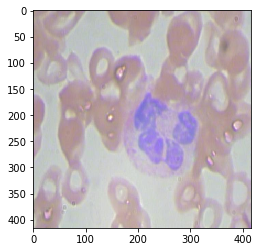

In [61]:
plt.imshow(X[0])

In [62]:
y[0]

array([[169., 153., 319., 325.,   0.],
       [ 50., 291., 119., 377.,   2.],
       [ 40., 205., 109., 291.,   2.],
       [139., 313., 208., 399.,   2.],
       [269., 305., 328., 385.,   2.],
       [360., 308., 416., 394.,   2.],
       [304., 357., 368., 416.,   2.],
       [  0., 288.,  56., 378.,   2.],
       [  2., 351.,  61., 416.,   2.],
       [100.,  64., 160., 150.,   2.],
       [  7.,  72.,  67., 140.,   2.],
       [347.,  33., 415., 120.,   2.],
       [355., 169., 416., 255.,   2.],
       [252.,   9., 312.,  96.,   2.],
       [111., 151., 171., 238.,   2.],
       [169.,   0., 243.,  71.,   2.],
       [148.,  78., 222., 150.,   2.],
       [ 44., 124., 119., 203.,   2.],
       [313., 113., 386., 199.,   2.],
       [239.,  77., 301., 152.,   2.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,

In [71]:
m = 0
for i in range(len(data_gen)):
    X, y = data_gen.__getitem__(i)
    print(y)
    break
#     img = X[0].copy()
#     for b in y[0][0:]:
#         b = [int(i) for i in b]
#         cv2.rectangle(img, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
#     plt.imshow(img)
#     plt.show()

(11, 5)
[[[156.  82. 232. 184.   2.]
  [251. 256. 327. 358.   2.]
  [315. 287. 391. 390.   2.]
  [341. 110. 416. 195.   2.]
  [360. 195. 416. 298.   2.]
  [285. 175. 353. 259.   2.]
  [264.  77. 332. 161.   2.]
  [282.   1. 350.  85.   2.]
  [ 69.  24. 137. 108.   2.]
  [120. 244. 261. 416.   0.]
  [  0. 108. 140. 326.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.]
  [  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


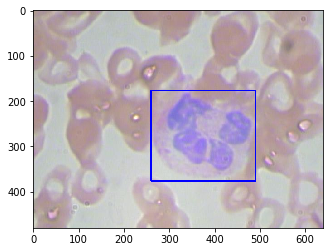

In [64]:
raw = cv2.imread('../dataset/train_img/BloodImage_00000.jpg')[:,:,::-1]
raw = raw / 255.
cv2.rectangle(raw, (260, 177), (491, 376), (0, 0, 255), 2)
plt.imshow(raw) # 260 177 491 376

In [75]:
y[0, :10]

array([[156.,  82., 232., 184.,   2.],
       [251., 256., 327., 358.,   2.],
       [315., 287., 391., 390.,   2.],
       [341., 110., 416., 195.,   2.],
       [360., 195., 416., 298.,   2.],
       [285., 175., 353., 259.,   2.],
       [264.,  77., 332., 161.,   2.],
       [282.,   1., 350.,  85.,   2.],
       [ 69.,  24., 137., 108.,   2.],
       [120., 244., 261., 416.,   0.]])

In [173]:
def preprocess_true_boxes(true_boxes, input_shape, anchors, num_classes):
    '''Preprocess true boxes to training input format

    Parameters
    ----------
    true_boxes: array, shape=(m, T, 5)
        Absolute x_min, y_min, x_max, y_max, class_id relative to input_shape.
    input_shape: array-like, hw, multiples of 32
    anchors: array, shape=(N, 2), wh
    num_classes: integer

    Returns
    -------
    y_true: list of array, shape like yolo_outputs, xywh are reletive value

    '''
    assert (true_boxes[..., 4]<num_classes).all(), 'class id must be less than num_classes'
    num_layers = len(anchors)//3 # default setting
    print('num_layers ', num_layers)
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

    true_boxes = np.array(true_boxes, dtype='float32')
    input_shape = np.array(input_shape, dtype='int32')
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 #(100, 2) (100, 2)
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
    print('boxes_xy boxes_wh', boxes_xy.shape, boxes_wh.shape)
    true_boxes[..., 0:2] = boxes_xy/input_shape[::-1]
    true_boxes[..., 2:4] = boxes_wh/input_shape[::-1]

    m = true_boxes.shape[0] # bs: 1
    print('m ', m)
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)]
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)] # (100, 13, 13, 3, 8) (100, 26, 26, 3, 8) (100, 52, 52, 3, 8)
    for i in range(3):
        print(f'y {i}', y_true[i].shape)

    # Expand dim to apply broadcasting.
    anchors = np.expand_dims(anchors, 0) # 1, 9 , 2
    print('anchors ', anchors.shape, anchors) 
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    print(anchor_maxes)
    valid_mask = boxes_wh[..., 0]>0  # 100,
    print('valid mask', valid_mask.shape) 

    for b in range(m):
        # Discard zero rows.
        wh = boxes_wh[b, valid_mask[b]]  # (1, 2)
        print('wh', wh.shape)
        if len(wh)==0: continue
        # Expand dim to apply broadcasting.
        wh = np.expand_dims(wh, -2) # (1, 1, 2)
        print('wh', wh.shape)
#         print(wh) # 76. 102
        box_maxes = wh / 2. # (1, 1, 2)
        box_mins = -box_maxes # (1, 1, 2)
#         print(box_maxes, box_mins) # [[[38. 51.]]] [[[-38. -51.]]]
        print('box_mins, anchor_mins', box_mins.shape, anchor_mins.shape)
        intersect_mins = np.maximum(box_mins, anchor_mins)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        print('intersect_mins', intersect_mins.shape)
#         print('intersect_mins', 'intersect_max', intersect_mins, intersect_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
#         print(intersect_wh)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] # (9,)
        print('intersect_area ', intersect_area)
#         print(intersect_area)
        box_area = wh[..., 0] * wh[..., 1]
        print('box_area ', box_area.shape)
        anchor_area = anchors[..., 0] * anchors[..., 1] # 1, 9
        print('anchor_area', anchor_area.shape)
        iou = intersect_area / (box_area + anchor_area - intersect_area)
        print('iou', iou.shape)

        # Find best anchor for each true box
        best_anchor = np.argmax(iou, axis=-1)
        print('best_anchor', best_anchor, best_anchor.shape)
        print('true_boxes ', true_boxes.shape)
        for t, n in enumerate(best_anchor): # t: idx, n:anchor idx
            for l in range(num_layers): # 3
                if n in anchor_mask[l]:
                    print('true_boxes[b,t,0]', true_boxes[b,t,0], b, t, 'grid_shapes[l]', grid_shapes[l])
                    i = np.floor(true_boxes[b,t,0]*grid_shapes[l][1]).astype('int32') # grid index
                    j = np.floor(true_boxes[b,t,1]*grid_shapes[l][0]).astype('int32') # grid index 
                    print(i, j)
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4] # bbox
                    y_true[l][b, j, i, k, 4] = 1 # confidence
                    y_true[l][b, j, i, k, 5+c] = 1 # one hot

    return y_true

In [174]:
anchors = np.array([12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401]).reshape((-1, 2))
print(anchors.shape)
# print('true_boxes ', y[:1].shape, y[:1])
a = preprocess_true_boxes(y[:1], (416, 416), anchors, num_classes=3)

(9, 2)
num_layers  3
boxes_xy boxes_wh (1, 100, 2) (1, 100, 2)
m  1
y 0 (1, 13, 13, 3, 8)
y 1 (1, 26, 26, 3, 8)
y 2 (1, 52, 52, 3, 8)
anchors  (1, 9, 2) [[[ 12  16]
  [ 19  36]
  [ 40  28]
  [ 36  75]
  [ 76  55]
  [ 72 146]
  [142 110]
  [192 243]
  [459 401]]]
[[[  6.    8. ]
  [  9.5  18. ]
  [ 20.   14. ]
  [ 18.   37.5]
  [ 38.   27.5]
  [ 36.   73. ]
  [ 71.   55. ]
  [ 96.  121.5]
  [229.5 200.5]]]
valid mask (1, 100)
wh (11, 2)
wh (11, 1, 2)
box_mins, anchor_mins (11, 1, 2) (1, 9, 2)
intersect_mins (11, 9, 2)
intersect_area  [[  192.   684.  1120.  2700.  4180.  7344.  7752.  7752.  7752.]
 [  192.   684.  1120.  2700.  4180.  7344.  7752.  7752.  7752.]
 [  192.   684.  1120.  2700.  4180.  7416.  7828.  7828.  7828.]
 [  192.   684.  1120.  2700.  4125.  6120.  6375.  6375.  6375.]
 [  192.   684.  1120.  2700.  3080.  5768.  5768.  5768.  5768.]
 [  192.   684.  1120.  2700.  3740.  5712.  5712.  5712.  5712.]
 [  192.   684.  1120.  2700.  3740.  5712.  5712.  5712.  5712.]

In [165]:
def preprocess_true_boxes2(true_boxes, input_shape, anchors, num_classes):
    '''Preprocess true boxes to training input format

    Parameters
    ----------
    true_boxes: array, shape=(m, T, 5)
        Absolute x_min, y_min, x_max, y_max, class_id relative to input_shape.
    input_shape: array-like, hw, multiples of 32
    anchors: array, shape=(N, 2), wh
    num_classes: integer

    Returns
    -------
    y_true: list of array, shape like yolo_outputs, xywh are reletive value

    '''
    assert (true_boxes[..., 4]<num_classes).all(), 'class id must be less than num_classes'
    num_layers = len(anchors)//3 # default setting
    print('num_layers ', num_layers)
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

    true_boxes = np.array(true_boxes, dtype='float32')
    input_shape = np.array(input_shape, dtype='int32')
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 #(100, 2) (100, 2)
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
    print('boxes_xy boxes_wh', boxes_xy.shape, boxes_wh.shape)
    true_boxes[..., 0:2] = boxes_xy/input_shape[::-1]
    true_boxes[..., 2:4] = boxes_wh/input_shape[::-1]

    m = true_boxes.shape[0] # bs: 1
    print('m ', m)
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)]
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)] # (100, 13, 13, 3, 8) (100, 26, 26, 3, 8) (100, 52, 52, 3, 8)
    for i in range(3):
        print(f'y {i}', y_true[i].shape)

    # Expand dim to apply broadcasting.
    anchors = np.expand_dims(anchors, 0) # 1, 9 , 2
    print('anchors ', anchors.shape, anchors) 
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    print(anchor_maxes)
    valid_mask = boxes_wh[..., 0]>0  # 100,
    print('valid mask', valid_mask.shape) 

    for b in range(m):
        # Discard zero rows.
        wh = boxes_wh[b, valid_mask[b]]  # (1, 2)
        print('wh', wh.shape)
        if len(wh)==0: continue
        # Expand dim to apply broadcasting.
        wh = np.expand_dims(wh, -2) # (1, 1, 2)
        print('wh', wh.shape)
#         print(wh) # 76. 102
        box_maxes = wh / 2. # (1, 1, 2)
        box_mins = -box_maxes # (1, 1, 2)
#         print(box_maxes, box_mins) # [[[38. 51.]]] [[[-38. -51.]]]
        print('box_mins, anchor_mins', box_mins.shape, anchor_mins.shape)
        intersect_mins = np.maximum(box_mins, anchor_mins)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        print('intersect_mins', intersect_mins.shape)
#         print('intersect_mins', 'intersect_max', intersect_mins, intersect_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
#         print(intersect_wh)
        intersect_area = np.prod(intersect_wh, axis=-1)
        print('intersect_area ', intersect_area)
#         print(intersect_area)
        box_area = wh[..., 0] * wh[..., 1]
#         print('box_area ', box_area)
        anchor_area = anchors[..., 0] * anchors[..., 1] # 1, 9
        print('anchor_area', anchor_area.shape)
        iou = intersect_area / (box_area + anchor_area - intersect_area)
#         print(iou)

        # Find best anchor for each true box
        best_anchor = np.argmax(iou, axis=-1)
        print(best_anchor, best_anchor.shape)
        print('true_boxes ', true_boxes.shape)
        for t, n in enumerate(best_anchor): # t: idx, n:anchor idx
            for l in range(num_layers): # 3
                if n in anchor_mask[l]:
                    print('true_boxes[b,t,0]', true_boxes[b,t,0], b, t, 'grid_shapes[l]', grid_shapes[l])
                    i = np.floor(true_boxes[b,t,0]*grid_shapes[l][1]).astype('int32') # grid index
                    j = np.floor(true_boxes[b,t,1]*grid_shapes[l][0]).astype('int32') # grid index 
                    print(i, j)
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4] # bbox
                    y_true[l][b, j, i, k, 4] = 1 # confidence
                    y_true[l][b, j, i, k, 5+c] = 1 # one hot

    return y_true

In [166]:
anchors = np.array([12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401]).reshape((-1, 2))
print(anchors.shape)
# print('true_boxes ', y[:1].shape, y[:1])
a = preprocess_true_boxes2(y[:1], (416, 416), anchors, num_classes=3)

(9, 2)
num_layers  3
boxes_xy boxes_wh (1, 100, 2) (1, 100, 2)
m  1
y 0 (1, 13, 13, 3, 8)
y 1 (1, 26, 26, 3, 8)
y 2 (1, 52, 52, 3, 8)
anchors  (1, 9, 2) [[[ 12  16]
  [ 19  36]
  [ 40  28]
  [ 36  75]
  [ 76  55]
  [ 72 146]
  [142 110]
  [192 243]
  [459 401]]]
[[[  6.    8. ]
  [  9.5  18. ]
  [ 20.   14. ]
  [ 18.   37.5]
  [ 38.   27.5]
  [ 36.   73. ]
  [ 71.   55. ]
  [ 96.  121.5]
  [229.5 200.5]]]
valid mask (1, 100)
wh (11, 2)
wh (11, 1, 2)
box_mins, anchor_mins (11, 1, 2) (1, 9, 2)
intersect_mins (11, 9, 2)
intersect_area  [[  192.   684.  1120.  2700.  4180.  7344.  7752.  7752.  7752.]
 [  192.   684.  1120.  2700.  4180.  7344.  7752.  7752.  7752.]
 [  192.   684.  1120.  2700.  4180.  7416.  7828.  7828.  7828.]
 [  192.   684.  1120.  2700.  4125.  6120.  6375.  6375.  6375.]
 [  192.   684.  1120.  2700.  3080.  5768.  5768.  5768.  5768.]
 [  192.   684.  1120.  2700.  3740.  5712.  5712.  5712.  5712.]
 [  192.   684.  1120.  2700.  3740.  5712.  5712.  5712.  5712.]

In [ ]:
intersect_area  [[  192.   684.  1120.  2700.  4180.  7344.  7752.  7752.  7752.]
 [  192.   684.  1120.  2700.  4180.  7344.  7752.  7752.  7752.]
 [  192.   684.  1120.  2700.  4180.  7416.  7828.  7828.  7828.]
 [  192.   684.  1120.  2700.  4125.  6120.  6375.  6375.  6375.]
 [  192.   684.  1120.  2700.  3080.  5768.  5768.  5768.  5768.]
 [  192.   684.  1120.  2700.  3740.  5712.  5712.  5712.  5712.]
 [  192.   684.  1120.  2700.  3740.  5712.  5712.  5712.  5712.]
 [  192.   684.  1120.  2700.  3740.  5712.  5712.  5712.  5712.]
 [  192.   684.  1120.  2700.  3740.  5712.  5712.  5712.  5712.]
 [  192.   684.  1120.  2700.  4180. 10512. 15510. 24252. 24252.]
 [  192.   684.  1120.  2700.  4180. 10512. 15400. 30520. 30520.]]
intersect_area  [[  192.   684.  1120.  2700.  4180.  7344.  7752.  7752.  7752.]
 [  192.   684.  1120.  2700.  4180.  7344.  7752.  7752.  7752.]
 [  192.   684.  1120.  2700.  4180.  7416.  7828.  7828.  7828.]
 [  192.   684.  1120.  2700.  4125.  6120.  6375.  6375.  6375.]
 [  192.   684.  1120.  2700.  3080.  5768.  5768.  5768.  5768.]
 [  192.   684.  1120.  2700.  3740.  5712.  5712.  5712.  5712.]
 [  192.   684.  1120.  2700.  3740.  5712.  5712.  5712.  5712.]
 [  192.   684.  1120.  2700.  3740.  5712.  5712.  5712.  5712.]
 [  192.   684.  1120.  2700.  3740.  5712.  5712.  5712.  5712.]
 [  192.   684.  1120.  2700.  4180. 10512. 15510. 24252. 24252.]
 [  192.   684.  1120.  2700.  4180. 10512. 15400. 30520. 30520.]]